<a href="https://colab.research.google.com/github/SpirinEgor/HSE.recommendation_systems/blob/master/homework_2/this_song_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab preparation

In [1]:
! nvidia-smi

Fri Nov 19 17:41:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install catboost

In [3]:
! git clone https://github.com/SpirinEgor/HSE.recommendation_systems
%cd HSE.recommendation_systems/homework_2

fatal: destination path 'HSE.recommendation_systems' already exists and is not an empty directory.
/content/HSE.recommendation_systems/homework_2


In [4]:
! git pull

Already up to date.


In [5]:
! mkdir data &&\
    cd data &&\
    wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz &&\
    tar -xzvf wsdm_data.tar.gz

mkdir: cannot create directory ‘data’: File exists


# Imports

In [70]:
import numpy as np
import seaborn as sns
from catboost import CatBoostRanker
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

from dataset import DatasetBuilder
from train_utils import yield_folds, create_pool
from embedding import Embedding

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Basic recommendation system

In [3]:
%%time

dataset_builder = DatasetBuilder("data", 25)
dataset, cat_features = dataset_builder.build_dataset()

Reading data...
Building embeddings for song...
	Building count vectors...
	Decomposing them with SVD...
	Explained variance of the SVD: 75%
Joining all data into one single table...
Processing categorical features...
CPU times: user 4min 25s, sys: 17.9 s, total: 4min 43s
Wall time: 3min 57s


In [4]:
print("Categorical features: " + ", ".join(cat_features))
dataset.head()

Categorical features: song_id, source_system_tab, source_screen_name, source_type, city, gender, registered_via, genre_ids, language, name, isrc


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,song_emb_16,song_emb_17,song_emb_18,song_emb_19,song_emb_20,song_emb_21,song_emb_22,song_emb_23,song_emb_24,song_emb_25
2013299,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,uLMnQqH4r82LRDcPEMA/OwLS5TVWRIeqH9411w3Fl+I=,0,0,0,0,0,39,0,0,...,0.131518,0.149625,-0.024155,-0.006163,0.093474,0.031063,0.041562,0.053009,0.054483,-0.084021
5205474,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,wbK99QQ6IfxNMLiygZ3/fFsHvnSSTuZS5/Z6i0+TbBI=,1,1,1,0,0,39,0,0,...,0.034150,-0.061191,-0.071639,-0.000283,0.062089,-0.015612,0.071615,0.039415,-0.012920,-0.043309
3831114,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,a1IJud+Jnryol8OvdRl153w11eJtiHnGUhIbC5ORglo=,1,2,2,0,0,39,0,0,...,0.092271,0.054858,-0.074598,0.017868,0.085494,0.118542,0.014418,0.026050,0.032436,0.032782
3831113,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,8MfpwhYW2MKgUi7dCUCgXVbMBrr4QJNb+uglFc3RDsQ=,1,2,2,0,0,39,0,0,...,0.106111,-0.017855,0.051495,0.017639,0.053811,0.027098,0.139428,-0.066588,0.066092,-0.002132
3831112,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,jDxR91QGVa/a/FoWgl6Kkm/w4mY5+apYEJbu/4By/hY=,1,2,2,0,0,39,0,0,...,0.001609,0.149972,-0.048172,-0.067428,-0.057114,0.061953,0.085970,-0.205031,0.059913,-0.045570


In [5]:
unique_users = np.unique(dataset["msno"])
print(f"Number of unique users: {unique_users.shape[0]}")

Number of unique users: 30601


In [10]:
parameters = {
    "iterations": 1,
    "custom_metric": ["NDCG", "QueryAUC:type=Ranking"],
    "random_seed": 7,
    "loss_function": "YetiRank",
    "allow_writing_files": False,
    "verbose": False,
    "metric_period": 1,
#     "task_type": "GPU"
}
eval_iterations = [
    i for i in range(parameters["iterations"])
    if i % parameters["metric_period"] == 0] + [parameters["iterations"] - 1
]

In [11]:
N_FOLDS = 5

scores = []
for train_idx, test_idx in tqdm(yield_folds(dataset["msno"], N_FOLDS), "Cross-validation", N_FOLDS):
    train_pool = create_pool(dataset.iloc[train_idx], cat_features)
    test_pool = create_pool(dataset.iloc[test_idx], cat_features)
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool)
    scores.append(model.get_evals_result())

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Final NDCG: 0.79 ± 0.007


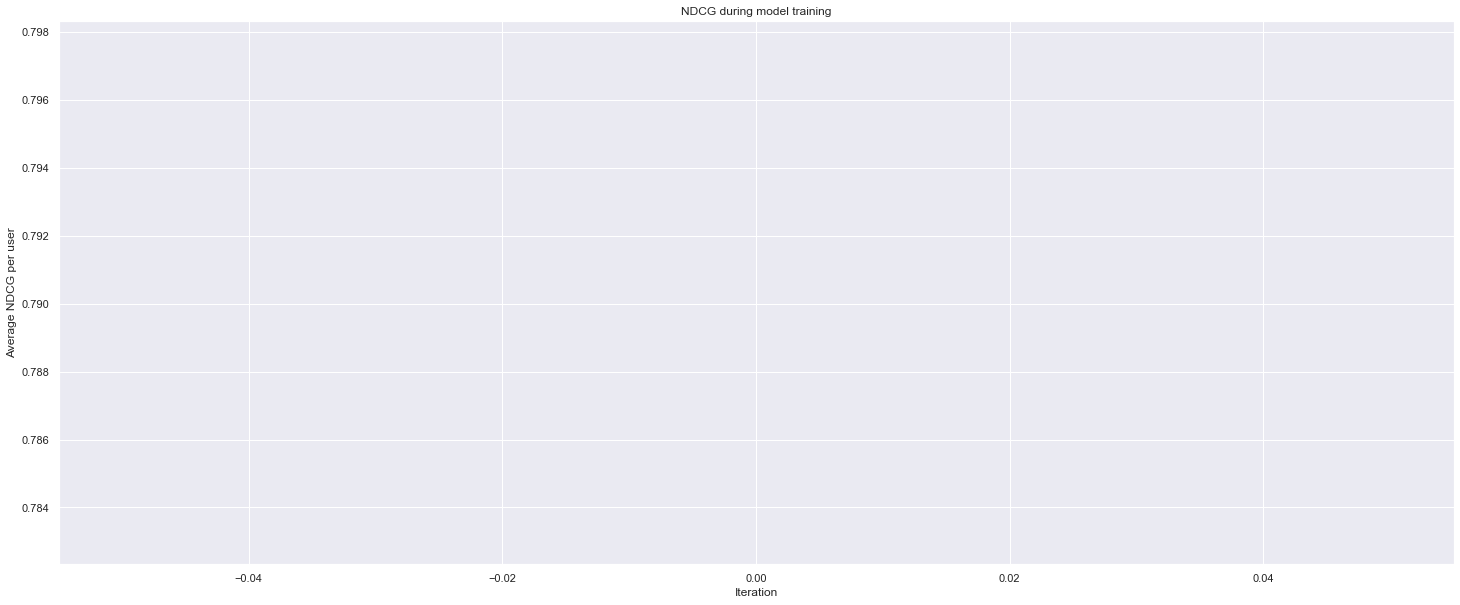

In [13]:
ndcgs = np.vstack([it["validation"]["NDCG:type=Base"] for it in scores])
m_ndcg = ndcgs.mean(axis=0)
s_ndcg = ndcgs.std(axis=0)

print(f"Final NDCG: {round(m_ndcg[-1], 3)} ± {round(s_ndcg[-1], 3)}")

sns.set_theme(rc={"figure.figsize": (25, 10)})

ax = sns.lineplot(x=eval_iterations, y=m_ndcg)
ax.set_title("NDCG during model training")
ax.set_ylabel("Average NDCG per user")
ax.set_xlabel("Iteration")
ax.fill_between(x=eval_iterations, y1=m_ndcg - s_ndcg, y2=m_ndcg + s_ndcg, alpha=.5)

Final ROC-AUC per user: 0.561 ± 0.001


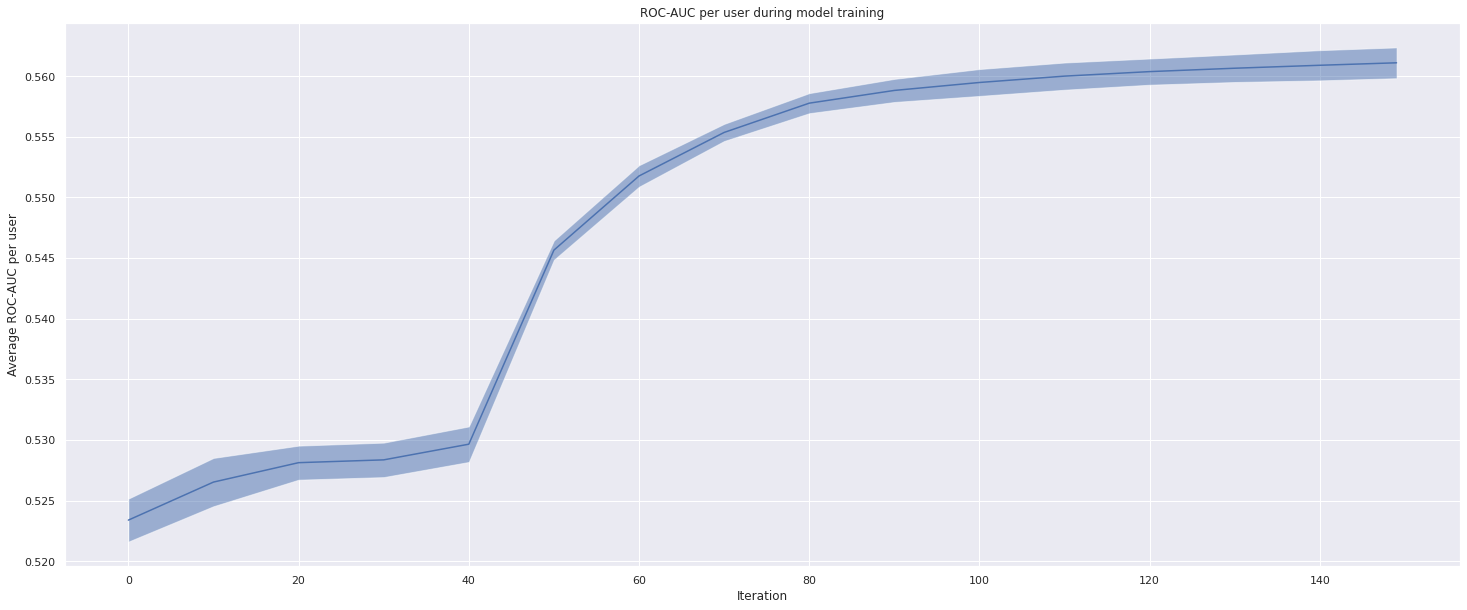

In [13]:
iterations = [i * 10 for i in range(10)] + [99]

aucs = np.vstack([it["validation"]["QueryAUC:type=Ranking"] for it in scores])
m_auc = aucs.mean(axis=0)
s_auc = aucs.std(axis=0)

print(f"Final ROC-AUC per user: {round(m_auc[-1], 3)} ± {round(s_auc[-1], 3)}")

sns.set_theme(rc={"figure.figsize": (25, 10)})

ax = sns.lineplot(x=eval_iterations, y=m_auc)
ax.set_title("ROC-AUC per user during model training")
ax.set_ylabel("Average ROC-AUC per user")
ax.set_xlabel("Iteration")
ax.fill_between(x=eval_iterations, y1=m_auc - s_auc, y2=m_auc + s_auc, alpha=.5)

In [81]:
y_pred = model.predict(test_pool)
y_pred.max()

0.0221196751909245

In [84]:
test = dataset.iloc[test_idx].copy()
test["pred"] = y_pred
test.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,song_emb_17,song_emb_18,song_emb_19,song_emb_20,song_emb_21,song_emb_22,song_emb_23,song_emb_24,song_emb_25,pred
3900722,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,F9rd0eHP2eQGEv5E0kZMaxNcw4KVaZTUIMH7M8Ft5Yw=,1,1,3,0,2,31,0,2,...,0.064504,-0.027916,-0.073823,-0.074575,0.040137,0.113113,-0.066622,0.096676,-0.178339,0.014351
6584737,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,ckcRutT2QoTR+/I4cjnL/6iCQs+Pf2ex33BceVb+ewg=,1,1,3,1,2,31,0,2,...,0.142146,-0.024823,-0.020293,0.004581,-0.002563,0.085806,-0.060299,-0.017110,-0.041038,0.014351
2221131,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,pkKADcjPLFdP9kX40L8dlmbLWkgUTqUB0LhurVLSTME=,1,1,3,1,2,31,0,2,...,0.149566,-0.023829,-0.006267,0.093175,0.030583,0.041781,0.052869,0.054386,-0.083771,0.014351
4065413,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,eUxVxX4A88PcRozp+QcfZmdOl9Rgysm2m/EsgoHPZ3A=,1,1,3,1,2,31,0,2,...,0.001506,-0.046783,0.098672,0.162589,-0.043235,-0.096922,-0.099941,-0.097095,-0.116443,0.022120
4063842,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,/QQ6Vm48ztrMjV3XZaCpj0tENzxq95s5+O+4LXTJE4w=,1,1,3,1,2,31,0,2,...,0.078117,0.055666,0.101786,-0.043792,0.057406,-0.079461,-0.038571,0.013215,0.062282,0.014351


# word2vec embeddings

In [71]:
embeddings = Embedding(128, random_seed=7)
embeddings.fit(dataset, 15)

In [74]:
top_genres = dataset["genre_ids"].value_counts().index.to_list()[1:5]
genres_mask = dataset["genre_ids"].isin(top_genres)
song_emb_mask = dataset["song_id"].apply(embeddings.has_embedding)
mask = genres_mask & song_emb_mask

In [75]:
songs = dataset[mask]["song_id"]
genres = dataset[mask]["genre_ids"].to_numpy()

In [76]:
pca = PCA(n_components=2, random_state=7)
emb_2d = pca.fit_transform(embeddings.item_embedding(songs))

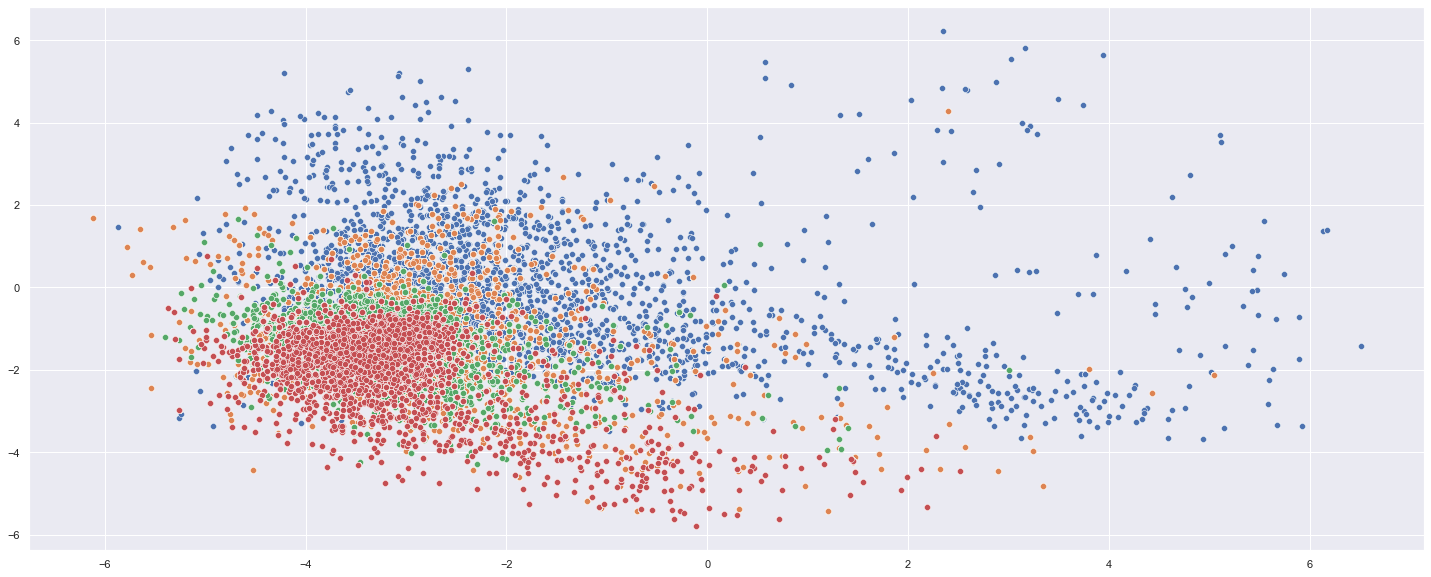

In [77]:
sns.set_theme(rc={"figure.figsize": (25, 10)})

for g in np.unique(genres):
    cur_mask = genres == g
    sns.scatterplot(x=emb_2d[cur_mask, 0], y=emb_2d[cur_mask, 1])